In [52]:
require 'cutorch'
require 'cunn'
require 'nn';
require 'model';
require 'mnist_loader';
Plot = require 'itorch.Plot';

In [53]:
cutorch.setDevice(1)

G, D = get_model()
G:cuda()
D:cuda()

criterion = nn.ClassNLLCriterion()
criterion = criterion:cuda()

In [54]:
train_set = mnist.loadTrainSet()

<mnist> done	


In [55]:
print(train_set.data:mean())
print(train_set.data:std())

0.5000000001501	


0.50000000007789	


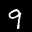

0	


In [56]:
displayData = train_set[1][1]
itorch.image(displayData)
print(train_set[1][2][9])

In [57]:
fixedLabelVector = torch.zeros(10, 10):cuda()
for m=1, 10 do
    fixedLabelVector[{m, m}] = 1
end
fixedNoise = torch.randn(10, 100):cuda()
print(fixedLabelVector)

 1  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  1
[torch.CudaTensor of size 10x10]



In [58]:
counter = 1
counter_tb = {}
D_fake_loss_tb = {}
D_real_loss_tb = {}
G_loss_tb = {}

G_parameters, G_gradParameters = G:getParameters()
D_parameters, D_gradParameters = D:getParameters()

In [59]:
print(G_parameters:mean())
print(G_parameters:std())
print(D_parameters:mean())
print(D_parameters:std())

0.00054262013873085	
0.027508603408933	
0.00017207470955327	
0.022674826905131	


## arguments for adam optimizer

In [60]:
lr = 1e-1
print(lr)

0.1	


In [61]:
-- gradclip = 5
lr = 2e-4
beta1 = 0.5
beta2 = 0.999
eps = 10e-8

batchsize = 128
epochsize = 10

G_m = torch.zeros(G_parameters:size()):cuda()
G_mt = torch.zeros(G_parameters:size()):cuda()
G_v = torch.zeros(G_parameters:size()):cuda()
G_vt = torch.zeros(G_parameters:size()):cuda()

D_m = torch.zeros(D_parameters:size()):cuda()
D_mt = torch.zeros(D_parameters:size()):cuda()
D_v = torch.zeros(D_parameters:size()):cuda()
D_vt = torch.zeros(D_parameters:size()):cuda()

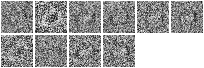

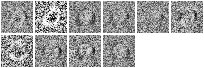

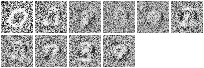

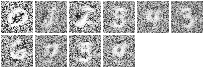

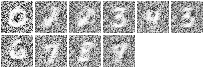

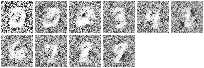

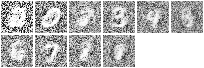

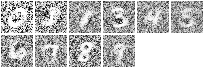

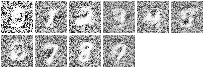

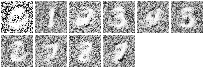

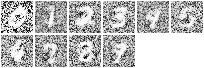

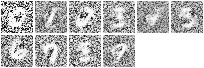

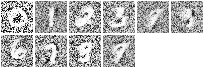

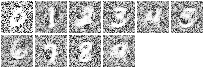

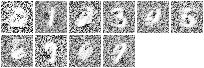

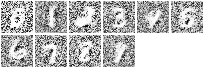

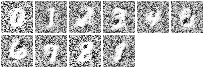

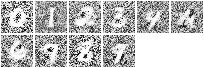

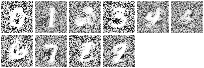

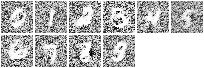

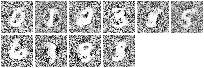

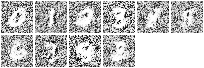

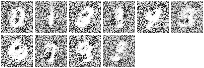

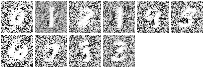

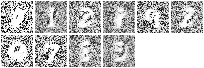

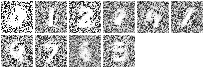

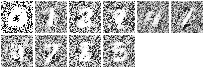

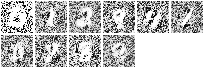

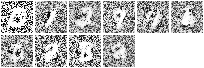

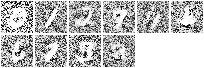

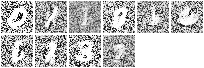

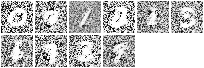

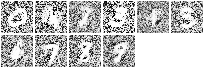

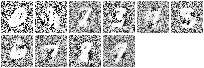

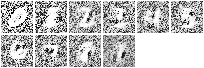

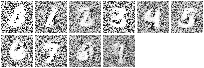

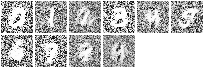

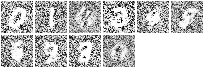

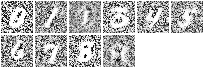

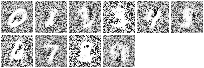

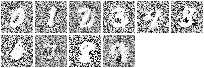

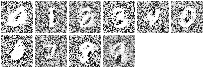

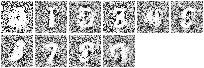

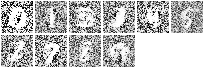

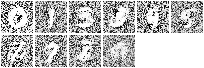

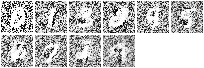

In [62]:
for epoch=1, epochsize do
    train_set:shuffle()
    if epoch == 30 then
        lr = lr / 10
    end
    if epoch == 40 then
        lr = lr / 10
    end
    for batch_count = 1, train_set:size() / batchsize do        
        inputImgInputBatch = torch.zeros(batchsize, 32, 32):cuda()
        inputVectorInputBatch = torch.zeros(batchsize, 10):cuda()
        for batch_count_idx = 1, batchsize do
            i = (batch_count - 1) * batchsize + batch_count_idx
            inputImgInput = train_set[i][1]:view(32, 32):cuda()
            inputVectorInput = train_set[i][2]:cuda()
            inputVectorInputBatch[batch_count_idx] = inputVectorInput
            inputImgInputBatch[batch_count_idx] = inputImgInput
        end    
        
        realPredBatch = D:forward({inputImgInputBatch, inputVectorInputBatch})
        real_target = 1
        D_backward = torch.zeros(batchsize, 2):cuda()
        
        D_real_loss_total = 0
        for batch_count_idx = 1, batchsize do
            D_real_loss = criterion:forward(realPredBatch[batch_count_idx], real_target)            
            D_real_loss_total = D_real_loss_total + D_real_loss
            
            D_criterion = criterion:backward(realPredBatch[batch_count_idx], real_target)            
           
            D_backward[batch_count_idx] = D_criterion                        
        end
                
        D_real_loss_total = D_real_loss_total / batchsize
        D:zeroGradParameters()
        D:backward({inputImgInputBatch, inputVectorInputBatch}, D_backward)
        
        D_gradParameters:div(batchsize)
        -- D_gradParameters:clamp(-gradclip, gradclip)

        D_gradParametersReal = D_gradParameters:clone()
        
            
        -- fake image
        noiseBatch = torch.randn(batchsize, 100):cuda()
        fakeImgBatch = G:forward({noiseBatch, inputVectorInputBatch})    
            
        fakePredBatch = D:forward({fakeImgBatch, inputVectorInputBatch})

        fake_target = 2
        D_backward = torch.zeros(batchsize, 2):cuda()
        D_fake_loss_total = 0
        for batch_count_idx = 1, batchsize do
            D_fake_loss = criterion:forward(fakePredBatch[batch_count_idx], fake_target)
            D_fake_loss_total = D_fake_loss_total + D_fake_loss
            D_criterion = criterion:backward(fakePredBatch[batch_count_idx], fake_target)
            D_backward[{{batch_count_idx}, {}}] = D_criterion:clone()
        end
        D_fake_loss_total = D_fake_loss_total / batchsize
        D:zeroGradParameters()
        fakeImgPrime = D:backward({fakeImgBatch, inputVectorInputBatch}, D_backward)
        
        
        D_gradParameters:div(batchsize)
        -- D_gradParameters:clamp(-gradclip, gradclip)
        
        D_gradParameters:add(D_gradParametersReal):div(2)
        
        -- update D parameters
        if (D_fake_loss_total + D_real_loss_total) / 2 > 0.6 then
            D_m:mul(beta1):add(torch.mul(D_gradParameters, 1-beta1))
            D_v:mul(beta2):add(torch.mul(torch.pow(D_gradParameters, 2), 1-beta2))

            -- correct m and v
            D_mt:copy(torch.div(D_m, 1-math.pow(beta1, counter)))
            D_vt:copy(torch.div(D_v, 1-math.pow(beta2, counter)))

            D_vt:sqrt():add(eps)
            D_mt:mul(-1*lr)
            D_parameters:add(D_mt:cdiv(D_vt))
        end
        -- generator
        G:zeroGradParameters()
        G:backward({noiseBatch, inputVectorInputBatch}, fakeImgPrime[1])
        G_gradParameters:div(batchsize)
        -- G_gradParameters:clamp(-gradclip, gradclip)
        
        G_m:mul(beta1):add(torch.mul(G_gradParameters, 1-beta1))
        G_v:mul(beta2):add(torch.mul(torch.pow(G_gradParameters, 2), 1-beta2))

        -- correct m and v
        G_mt:copy(torch.div(G_m, 1-math.pow(beta1, counter)))
        G_vt:copy(torch.div(G_v, 1-math.pow(beta2, counter)))

        G_vt:sqrt():add(eps)
        G_mt:mul(1*lr)
        G_parameters:add(G_mt:cdiv(G_vt))
        
        -- G:updateParameters(lr)

        
        fakeImgBatch = G:forward({noiseBatch, inputVectorInputBatch})
        fakePredBatch = D:forward({fakeImgBatch, inputVectorInputBatch})
        
        G_loss_total = 0
        for batch_count_idx = 1, batchsize do
            G_loss = criterion:forward(fakePredBatch[batch_count_idx], fake_target)
            G_loss_total = G_loss_total + G_loss
        end
        G_loss_total = G_loss_total / batchsize
            
        counter = counter + 1        
        if counter % 100 == 0 then
            
            table.insert(counter_tb, counter)
            table.insert(D_fake_loss_tb, D_fake_loss_total)
            table.insert(D_real_loss_tb, D_real_loss_total)
            table.insert(G_loss_tb, G_loss_total)
            local res = G:forward({fixedNoise, fixedLabelVector}) + 0.5
            itorch.image(res)
        end
    end
end

In [63]:
print(#counter_tb)
print(#D_fake_loss_tb)

In [64]:
plot = Plot():line(counter_tb, D_fake_loss_tb, "red", "D fake loss")
plot:line(counter_tb, D_real_loss_tb, "pink", "D real loss")
plot:line(counter_tb, G_loss_tb, "blue", "G loss")
plot:title("gan training loss plot")
plot:draw()
plot:save("gan_training_loss_plot.html")

46	
46	


## debug part

 1  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  1
[torch.CudaTensor of size 10x10]



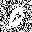

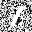

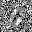

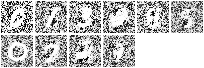

In [65]:
labelVector = torch.zeros(10, 10):cuda()
            
for m=1, 10 do
    labelVector[{m, m}] = 1
end
print(labelVector)
noise = torch.randn(10, 100):cuda()

local res = G:forward({noise, labelVector}) + 0.5
itorch.image(res[1])
itorch.image(res[2])
print(itorch.image(res[1] - res[2]))
itorch.image(res)

In [66]:
inputImgInputBatch = torch.zeros(batchsize, 32, 32):cuda()
inputVectorInputBatch = torch.zeros(batchsize, 10):cuda()
batch_count = 1
for batch_count_idx = 1, batchsize do
    i = (batch_count - 1) * batchsize + batch_count_idx
    inputImgInput = train_set[i][1]:view(32, 32):cuda()
    inputVectorInput = train_set[i][2]:cuda()
    inputVectorInputBatch[batch_count_idx] = inputVectorInput
    inputImgInputBatch[batch_count_idx] = inputImgInput
end    

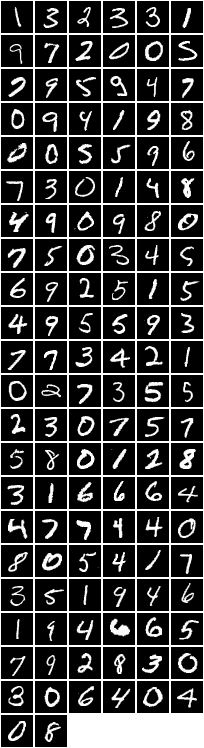

In [67]:
itorch.image(inputImgInputBatch)

In [68]:
print(inputVectorInputBatch)

 0  1  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  1  0  0
 0  0  1  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  1
 0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0
 1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1
 0  0  0  0  1  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  1  0
 1  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  0  0
 0  0  0  1  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0
 0  1  0  